<a href="https://colab.research.google.com/github/Prabhitha/Image_Colorization/blob/main/Image_Colorization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import cv2
import glob
import shutil
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from skimage.io import imread, imshow
from skimage.color import rgb2lab, lab2rgb


from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras.layers import Conv2D, MaxPool2D, UpSampling2D, Input, LeakyReLU

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!wget http://images.cocodataset.org/zips/train2017.zip
!unzip '/content/train2017.zip' > /dev/null

In [ ]:
train_root = '/content/train2017'
dest = '/content/train/Images'

if not os.path.exists(dest):
  os.makedirs(dest)

  for img in os.listdir(train_root):
    origin = os.path.join(train_root, img)
    shutil.copy(origin, dest)

In [ ]:
train_datagen = ImageDataGenerator(rescale= 1/255,
                                   featurewise_center= True,
                                   rotation_range= 40,
                                   horizontal_flip= True,
                                   vertical_flip= True)

train_generator = train_datagen.flow_from_directory('/content/train',
                           batch_size= 32,
                           shuffle= True)

Found 118287 images belonging to 1 classes.


In [ ]:
len(train_generator)

3697

In [ ]:
# Store the data in train_img, train_label variables by iterating over the batches

batch_size = 32

train_img, train_label = next(train_generator)
for i in tqdm(range(int(len(train_generator)/batch_size)-1)): #1st batch is already fetched before the for loop.
  img, label = next(train_generator)
  train_img = np.append(train_img, img, axis=0 )
  train_label = np.append(train_label, label, axis=0)
print(train_img.shape, train_label.shape)

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
100%|██████████| 114/114 [02:20<00:00,  1.23s/it]

(3680, 256, 256, 3) (3680, 1)


In [ ]:
train_img.shape

(3680, 256, 256, 3)

In [ ]:
def plotImage(img_arr):
  fig, ax = plt.subplots(nrows=1, ncols=8, figsize=(15,15))
  print("Shape of data:", img_arr[0].shape)
  # view train images
  for i in range(8):
    # plot image
    ax[i].imshow(img_arr[i]) 
    ax[i].axis('off')
    plt.show

Shape of data: (256, 256, 3)


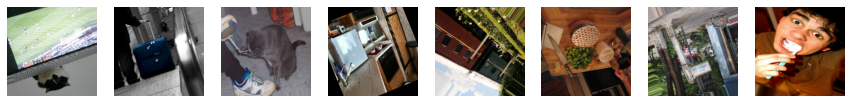

In [ ]:
# Image after Data Augmentation

plotImage(train_img[:8])

In [ ]:
x = []
y = []

for img in train_img:
  try:
    lab= rgb2lab(img)
    x.append(lab[:,:,0])
    y.append(lab[:,:,1:]/ 128)
  except:
    print('Error')

In [ ]:
x_train = np.array(x)
x_train = np.expand_dims(x_train, axis = len(x_train.shape))

y_train = np.array(y)

In [ ]:
x_train.shape, y_train.shape

((3680, 256, 256, 1), (3680, 256, 256, 2))

## Build our Model

In [ ]:
# Encoder
model = Sequential()

model.add(Conv2D(64,(3,3), activation='relu', padding='same', strides=2, input_shape=(256,256,1)))
model.add(Conv2D(128,(3,3), activation='relu', padding='same'))
model.add(Conv2D(128,(3,3), activation='relu', padding='same', strides=2))
model.add(Conv2D(256,(3,3), activation='relu', padding='same'))
model.add(Conv2D(256,(3,3), activation='relu', padding='same', strides=2))
model.add(Conv2D(512,(3,3), activation='relu', padding='same'))
model.add(Conv2D(512,(3,3), activation='relu', padding='same'))
model.add(Conv2D(256,(3,3), activation='relu', padding='same'))

# Decoder
model.add(Conv2D(128,(3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2,2)))
model.add(Conv2D(64,(3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2,2)))
model.add(Conv2D(32,(3,3), activation='relu', padding='same'))
model.add(Conv2D(16,(3,3), activation='relu', padding='same'))
model.add(Conv2D(2,(3,3), activation=LeakyReLU(alpha=0.01), padding='same'))
model.add(UpSampling2D((2,2)))

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_52 (Conv2D)          (None, 128, 128, 64)      640       
                                                                 
 conv2d_53 (Conv2D)          (None, 128, 128, 128)     73856     
                                                                 
 conv2d_54 (Conv2D)          (None, 64, 64, 128)       147584    
                                                                 
 conv2d_55 (Conv2D)          (None, 64, 64, 256)       295168    
                                                                 
 conv2d_56 (Conv2D)          (None, 32, 32, 256)       590080    
                                                                 
 conv2d_57 (Conv2D)          (None, 32, 32, 512)       1180160   
                                                                 
 conv2d_58 (Conv2D)          (None, 32, 32, 512)      

In [ ]:
model.compile(optimizer='Adam', metrics=['accuracy'], loss='categorical_crossentropy')

In [ ]:
print(x_train.shape)
print(x_train.shape[0])
history = model.fit(x_train, y_train, epochs=30, batch_size=32, steps_per_epoch=x_train.shape[0]//32, verbose=1)

(3680, 256, 256, 1)
3680
Epoch 1/30
115/115 [==============================] - 442s 4s/step - loss: 0.0366 - accuracy: 0.6337
Epoch 2/30
115/115 [==============================] - 455s 4s/step - loss: 0.0347 - accuracy: 0.6361
Epoch 3/30
115/115 [==============================] - 452s 4s/step - loss: 0.0346 - accuracy: 0.6361
Epoch 4/30
115/115 [==============================] - 456s 4s/step - loss: 0.0345 - accuracy: 0.6361
Epoch 5/30
115/115 [==============================] - 451s 4s/step - loss: 0.0343 - accuracy: 0.6360
Epoch 6/30
115/115 [==============================] - 450s 4s/step - loss: 0.0344 - accuracy: 0.6360
Epoch 7/30
115/115 [==============================] - 448s 4s/step - loss: 0.0357 - accuracy: 0.6361
Epoch 8/30
115/115 [==============================] - 452s 4s/step - loss: 0.0359 - accuracy: 0.6361
Epoch 9/30
115/115 [==============================] - 451s 4s/step - loss: 0.0348 - accuracy: 0.6361
Epoch 10/30
115/115 [==============================] - 452s 4s/ste

In [ ]:
model.save('/content/bestmodel.h5')

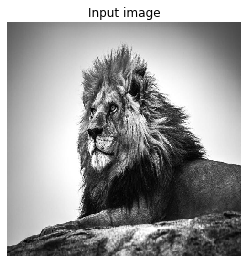

In [ ]:
img_color = []
path = '/content/blinq-art-black-white-default.jpg'

img = img_to_array(load_img(path, target_size=(256,256,3  )))/255

plt.title("Input image")
imshow(img)
plt.axis('off')
plt.show()

In [ ]:
img_color.append(img)

img_color = rgb2lab(img_color)[:,:,:,0]

img_color = img_color.reshape(img_color.shape+(1,))

In [ ]:
output = model.predict(img_color)
output = output*128

In [ ]:
result = np.zeros((256,256,3))
result[:,:,0] = img_color[0][:,:,0]
result[:,:,1:] = output[0]

In [ ]:
imshow(lab2rgb(result))

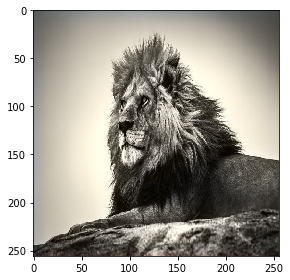

In [ ]:
imshow(lab2rgb(result))